# Modeling

Julian Domingo - jad5348

This file contains my process for training my base learners and meta learner to predict the probability values for the target value **Y**.

In [100]:
# Computation / Data Analysis stuff
import numpy as np
import pandas as pd
from scipy.stats import skew, probplot, norm
from scipy.special import boxcox1p

# Modeling stuff
from xgboost import XGBClassifier
from sklearn.model_selection import (RandomizedSearchCV, 
                                     GridSearchCV, 
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cross_validation import train_test_split, KFold

# Plotting stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pandas.tools.plotting import scatter_matrix

# Plotting visuals stuff
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# ignore warnings (i.e. deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [121]:
test_ids = pd.read_csv("./data/raw/test.csv")[["id"]]

## Helper Functions

In [91]:
def get_data(filename):
    train = pd.read_csv("./data/refined/train/train_{}.csv".format(filename))
    test = pd.read_csv("./data/refined/test/test_{}.csv".format(filename))
    
    x_train = train.drop(["Y"], axis = 1)
    y_train = train["Y"]
    
    return train, test, x_train, y_train

In [92]:
train_base, test_base, x_train_base, y_train_base = get_data("base")
train_log, test_log, x_train_log, y_train_log = get_data("log")
train_scaled, test_scaled, x_train_scaled, y_train_scaled = get_data("scaled")

## Modeling Functions

In [102]:
def get_cross_val_score(model, x_train, y_train, n_folds):
    cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = 'roc_auc', n_jobs = -1)
    print("Cross validation score: {} +/- {}\nRaw scores: {}".format(str(np.mean(cv)), str(np.std(cv)), str(cv)))
    return cv

def train_and_save_base_learner_preds(model, folds, x_train, y_train, test, pred_filename):
    # Train model on the folds defined
    result = train(model, folds, x_train, y_train, test)
        
    train_preds_csv = pd.DataFrame(columns=["Y"], index=x_train.index, data = result["train_preds"])
    train_preds_csv.to_csv("./predictions/train/train_{}.csv".format(pred_filename))
    
    test_preds_csv = pd.DataFrame(columns=["Y"], index=test.index, data=result["test_preds"])
    test_preds_csv.to_csv("./predictions/test/test_{}.csv".format(pred_filename))
    
    return result["model"]
                          

def train(model, folds, x, y, test):
    """ Trains the model through (stratified) CV. 
    
    'train_preds' is the combination of all predictions from each holdout.
    'test_preds' is the final predictions computed through the mean of each test prediction.
    
    """
    x = np.array(x)
    y = np.array(y)
    test = np.array(test)
        
    train_preds = np.zeros(x.shape[0])
    test_preds = np.zeros(test.shape[0])
    test_preds_iter = np.zeros((test.shape[0], len(folds)))
    
    for i, (train_indices, test_indices) in enumerate(folds):
        x_train = x[train_indices]
        x_holdout = x[test_indices]
        y_train = y[train_indices]
        
        %time model.fit(x_train, y_train)
        
        train_preds[test_indices] = model.predict_proba(x_holdout)[:,1]
        test_preds_iter[:,i] = model.predict_proba(test)[:,1]
        
    test_preds[:] = test_preds_iter.mean(1)
        
    return {'model': model, 'train_preds': train_preds ,'test_preds': test_preds}

In [94]:
# Obtain fold indices for base learner training.
n_splits = 5
folds = list(StratifiedKFold(n_splits, random_state=seed).split(x_train_base, y_train_base))

## Base Learners

#### Random Forest Classifier

Tuning parameters
    * n_estimators (online): "n_estimators is not really worth optimizing. The more estimators you give it, the better it will do. 500 or 1000 is usually sufficient."
    * criterion (class): Constantine mentioned entropy is the preferred criterion for Random Forests.
    * max_features (code): used GridSearchCV, sci-kit learn docs showed [1, 3, 10] as good contenders.

In [95]:
rfc_param_grid = {
    'max_features': [1, 3, 10]
}

rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1)

gs_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=n_splits, scoring="roc_auc")
gs_rfc.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 3, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [107]:
# So, we'll use 10 to be our max_features value.
print gs_rfc.best_params_
print gs_rfc.best_score_

{'max_features': 10}
0.750506293137


In [105]:
# Train with our optimized parameters.
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10, n_estimators=1000, n_jobs=-1)
rfc = train_and_save_base_learner_preds(rfc, folds, x_train_base, y_train_base, test_base, "random_forest_base")
rf_cv = get_cross_val_score(rfc, x_train_base, y_train_base, n_splits)

CPU times: user 44 s, sys: 417 ms, total: 44.4 s
Wall time: 7.78 s
CPU times: user 43.9 s, sys: 383 ms, total: 44.3 s
Wall time: 7.75 s
CPU times: user 43.5 s, sys: 353 ms, total: 43.8 s
Wall time: 7.84 s
CPU times: user 43.7 s, sys: 359 ms, total: 44 s
Wall time: 7.64 s
CPU times: user 43.3 s, sys: 354 ms, total: 43.7 s
Wall time: 7.77 s
Cross validation score: 0.74792660538 +/- 0.0159539543648
Raw scores: [ 0.75121725  0.76470151  0.72537649  0.73385839  0.76447939]


In [109]:
rfc.fit(x_train_base, y_train_base)
probs = rfc.predict_proba(test_base)[:,1]
print probs

array([ 0.9683427 ,  0.84006011,  0.932847  , ...,  0.8995378 ,
        0.97463642,  0.96310475])

In [123]:
submission = pd.DataFrame({"id": test_ids.id, "Y": probs})
submission.to_csv("./submissions/random_forest_lone.csv", index=False, columns=["id", "Y"])

Let's see what features RandomForestClassifier deemed most important.

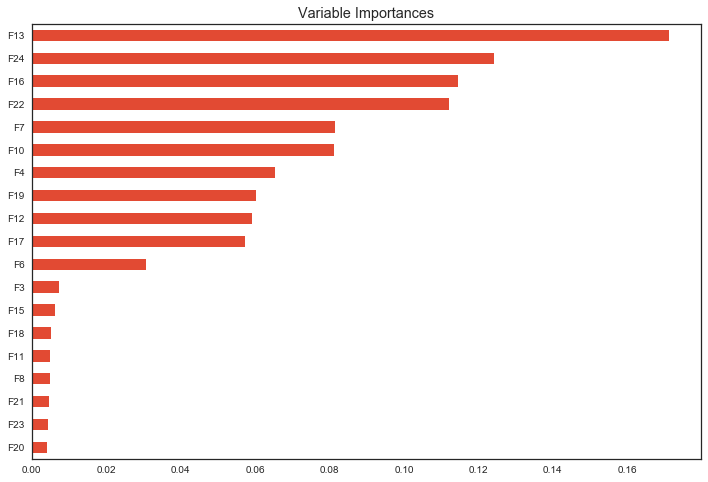

In [127]:
pd.Series(index=x_train_base.columns, data=rfc.feature_importances_).sort_values().plot(kind='barh', title='Variable Importances')

In [80]:
x_train_base.shape

(16383, 19)

In [81]:
test_base.head()

,id,F3,F4,F6,F7,F8,F10,F11,F12,F13,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24
0,16384,0,33,17000,143022,1,140341,1,122020,135753,1,128168,121276,1,122084,1,1,127696,1,36129
1,16385,0,38,18000,315517,1,138050,1,121506,55012,1,121648,120763,1,119703,1,2,127441,1,90582
2,16386,1,27,1000,142929,1,137960,1,121709,23834,1,314350,120965,1,119703,1,1,127029,1,46088
3,16387,0,33,2000,130186,1,128090,1,120286,92412,1,140144,180952,1,118961,1,1,127973,1,83138
4,16388,0,40,2000,132071,1,128051,1,138055,8513,1,121642,136961,1,118832,1,1,126927,1,92381


In [78]:
train_base.head()

,id,Y,F3,F4,F6,F7,F8,F10,F11,F12,...,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24
0,1,1,0,38,1000,32020,1,127959,1,120193,...,1,119757,119100,1,118830,1,1,126461,1,46871
1,2,1,0,41,1000,130630,1,128342,2,122242,...,1,138110,121149,1,118832,1,1,130296,1,42386
2,3,1,0,50,1000,303218,2,128299,1,120221,...,1,119777,119126,1,118832,1,2,127063,1,23968
3,4,1,0,45,2000,19024,1,127968,1,124605,...,2,270637,123511,1,118832,1,1,15274,1,27555
4,5,1,0,41,1000,303218,1,128299,1,120635,...,1,119777,119542,1,118832,1,1,133491,1,50260


In [ ]:
# def stack_model(model, train, test, y, new_feature):
#     model.fit(train, y)
#     train[new_feature] = pd.DataFrame(model.predict(train))
#     test[new_feature] = pd.DataFrame(model.predict(test))
    
#     return train, test

In [ ]:
# def get_out_of_folds_preds(k, model, x_train, x_test, y_train):
#     """ Returns the out of folds predictions of the model passed. """
#     len_train = x_train.shape[0]
#     len_test = x_test.shape[0]
#     kf = KFold(len_train, n_folds = k, random_state = 1337)
    
#     oof_train = np.zeros((len_train,))
#     oof_test = np.zeros((len_test,))
#     oof_test_kf = np.empty((k, len_test))
    
#     for i, (train_indices, test_indices) in enumerate(kf):
#         model.fit(x_train[train_indices], y_train[train_indices])
        
#         oof_train[test_indices] = model.predict(x_train[test_indices])
#         oof_test_kf[i, :] = model.predict(x_test)

#     oof_test[:] = oof_test_kf.mean(axis = 0)
    
#     return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# def get_base_learners():
#     # Parameters for each base model.
#     rf_params = {
#         'n_jobs': -1, # Number of cores used in training == all cores
#         'n_estimators': 10, # Number of classification trees in model
#         'warm_start': True,
#         'max_depth': 3, # Max depth of the tree. WARNING - don't set too high, otherwise may overfit
#         'min_samples_leaf': 2, # The minimum number of samples required to be at a leaf node 
#         'max_features' : 'sqrt', # The number of features to consider when looking for the best split
#         'verbose': 0,
#         'random_state': seed
#         # TODO: tune hyperparameters
#     }

#     xgb_params = {
#         # TODO: tune hyperparameters
#     }

#     et_params = {
#         # TODO: tune hyperparameters
#     }

#     ada_params = {
#         # TODO: tune hyperparameters
#     }

#     gb_params = {
#         # TODO: tune hyperparameters
#         'n_estimators': 100,
#         'random_state': seed
#     }

#     svc_params = {
#         # TODO: tune hyperparameters
#         'C': 100 # Penalty parameter of error term
#     }

#     lr_params = {
#         # TODO: tune hyperparameters
#         'C': 100, # Regularization strength
#         'random_state': seed
#     }

#     mlp_params = {
#         # TODO: tune hyperparameters
#         'hidden_layer_sizes': (80, 10),
#         'early_stopping': False,
#         'random_state': seed
#     }
    
#     knn_params = {
#         # TODO: tune hyperparameters
#         'n_neighbors': 3
#     }

#     nb = GaussianNB()
#     knn = KNeighborsClassifier(**knn_params)
#     rf = RandomForestClassifier(**rf_params)
#     xgb = XGBClassifier(**xgb_params)
#     et = ExtraTreesClassifier(**et_params)
#     lr = LogisticRegression(**lr_params)
#     ada = AdaBoostClassifier(**ada_params)
#     gb = GradientBoostingClassifier(**gb_params)
#     svc = SVC(**svc_params)
    
#     return {'rf': rf,
#             'et': et,
#             'lr': lr,
#             'ada': ada,
#             'svc': svc,
#             'nb': nb,
#             'gb': gb,
#             'knn': knn,
#             'xgb': xgb}

In [ ]:
# num_folds = 5

# x_train_vals = x_train.values
# x_test_vals = x_test.values
# y_vals = y.ravel()

# rf_train, rf_test = get_out_of_folds_preds(num_folds, rf, x_train_vals, x_test_vals, y_vals)
# xgb_train, xgb_test = get_out_of_folds_preds(num_folds, xgb, x_train_vals, x_test_vals, y_vals)
# ada_train, ada_test = get_out_of_folds_preds(num_folds, ada, x_train_vals, x_test_vals, y_vals)
# gb_train, gb_test = get_out_of_folds_preds(num_folds, gb, x_train_vals, x_test_vals, y_vals)
# svc_train, svc_test = get_out_of_folds_preds(num_folds, svc, x_train_vals, x_test_vals, y_vals)
# et_train, et_test = get_out_of_folds_preds(num_folds, et, x_train_vals, x_test_vals, y_vals)

# TODO: include Logistic Regressor
# lr_train, lr_test = get_out_of_folds_preds(num_folds, lr, x_train_vals, x_test_vals, y_vals)
    
# Feature importances for ensemble models.
# rf_importance = rf.fit(x_train.values, y.ravel()).feature_importances_
# xgb_importance = xgb.fit(x_train.values, y.ravel()).feature_importances_
# ada_importance = ada.fit(x_train.values, y.ravel()).feature_importances_
# gb_importance = gb.fit(x_train.values, y.ravel()).feature_importances_
# et_importance = et.fit(x_train.values, y.ravel()).feature_importances_

# print ("Random Forest Classifier feature importances:\n{}".format(rf_importance))
# print ("XGBoost Classifier feature importances:\n{}".format(xgb_importance))
# print ("AdaBoost Classifier feature importances:\n{}".format(ada_importance))
# print ("Gradient Boosting Classifier feature importances:\n{}".format(gb_importance))
# print ("Extra Trees Classifier feature importances:\n{}".format(et_importance))

In [ ]:
# # Train the base learners.
# for (model_name, model) in base_learners.items():
#     x_train, x_test = stack_model(model, x_train, x_test, y, model_name)

In [ ]:
# # Feed the base learner predictions into the meta learner, and predict with meta learner.
# meta_learner = XGBClassifier()
# meta_learner.fit(x_train, y)
# predictions = meta_learner.predict(x_test)
# submission = pd.DataFrame({"id": test.id, "Y": predictions})
# submission.to_csv('./results.csv', index = False, columns = ["id", "Y"])